In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def append_this(fn):
    return fn+".png"

df=pd.read_csv('/kaggle/input/rsna-bone-age/boneage-training-dataset.csv', dtype=str)
df_t=pd.read_csv("/kaggle/input/rsna-bone-age/boneage-test-dataset.csv",dtype=str)

df["id"]=df["id"].apply(append_this)
df['Boneage'] = df['boneage'].astype(int)
del(df['boneage'])
df_t["Case ID"]=df_t["Case ID"].apply(append_this)

In [3]:
del(df['male'])
del(df_t['Sex'])

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

image_size=256

data_gen=ImageDataGenerator(
                height_shift_range=0.2,
                width_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=False,
                preprocessing_function=preprocess_input,
                zoom_range=0.2,
                validation_split=0.20
            )

data_gen_test=ImageDataGenerator(
                preprocessing_function=preprocess_input,
            )

In [5]:
train_generator=data_gen.flow_from_dataframe(
    dataframe=df,
    directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/",
    x_col="id",
    y_col="Boneage",
    subset="training",
    batch_size=10,
    seed=42,
    shuffle=True,
    target_size=(image_size,image_size),
    class_mode='raw'
    )

validation_generator=data_gen.flow_from_dataframe(
    dataframe=df,
    directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/",
    x_col="id",
    y_col="Boneage",
    subset="validation",
    batch_size=10,
    seed=42,
    shuffle=True,
    target_size=(image_size,image_size),
    class_mode='raw'
)

test_generator=data_gen_test.flow_from_dataframe(
    dataframe=df_t,
    directory="../input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset/",
    x_col="Case ID",
    y_col=None,
    seed=42,
    target_size=(image_size,image_size),
    class_mode=None
)

Found 10089 validated image filenames.
Found 2522 validated image filenames.
Found 200 validated image filenames.


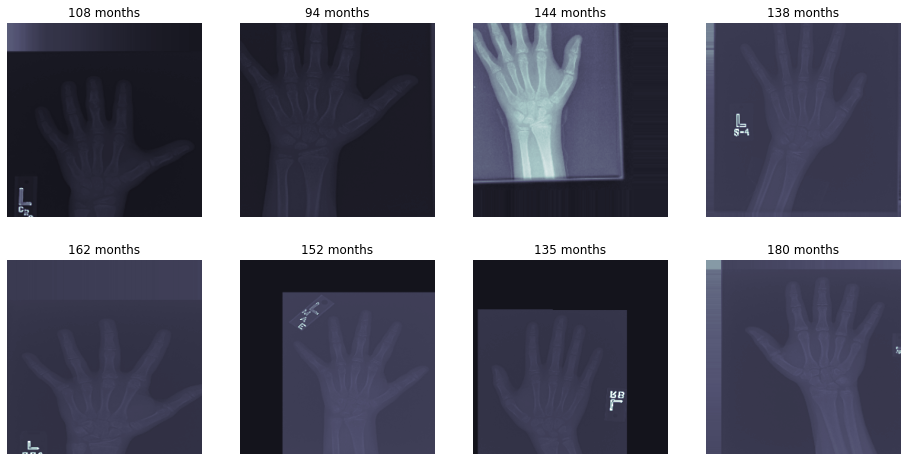

In [76]:
import cv2
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip (x_val, y_val, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%2.0f months' % (c_y))
    c_ax.axis('off')

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
model=Sequential()
model.add(VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
model.layers[0].trainable=False
model.compile(loss='mse', optimizer='adam', metrics=['MeanSquaredError'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 18,909,249
Trainable params: 4,194,561
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
model.fit_generator(train_generator,
                   validation_data=validation_generator,
                   epochs=12,
                   )

Train for 1009 steps, validate for 253 steps
Epoch 1/12
1009/1009 [==============================] - 653s 647ms/step - loss: 965.8108 - MeanSquaredError: 965.8699 - val_loss: 2031.6108 - val_MeanSquaredError: 2030.3904
Epoch 2/12
1009/1009 [==============================] - 632s 626ms/step - loss: 615.2013 - MeanSquaredError: 615.1862 - val_loss: 1658.1389 - val_MeanSquaredError: 1658.2373
Epoch 3/12
1009/1009 [==============================] - 609s 604ms/step - loss: 566.2301 - MeanSquaredError: 566.2400 - val_loss: 1760.1523 - val_MeanSquaredError: 1761.7072
Epoch 4/12
1009/1009 [==============================] - 649s 644ms/step - loss: 546.3974 - MeanSquaredError: 546.3982 - val_loss: 1372.7087 - val_MeanSquaredError: 1375.5621
Epoch 5/12
1009/1009 [==============================] - 598s 593ms/step - loss: 519.3293 - MeanSquaredError: 519.3243 - val_loss: 1452.1897 - val_MeanSquaredError: 1453.0447
Epoch 6/12
1009/1009 [==============================] - 592s 587ms/step - loss: 523.7

In [64]:
y_pred=model.predict_generator(test_generator)
preds=y_pred.flatten()

In [65]:
import csv
df_temp=pd.read_csv("/kaggle/input/rsna-bone-age/boneage-test-dataset.csv")
filenames=df_temp['Case ID']
results=pd.DataFrame({"Filename":filenames,
                      "Predictions": preds})
results.to_csv("predictions.csv",index=False)